# **Framing The Problem**

---


Movie Genre Classification using TF-IDF and Naive Bayes
Aim is to build a machine learning model to predict the genre of a movie based on its plot summary or textual information. To achieve this, we will leverage  TF-IDF (Term Frequency-Inverse Document Frequency) technique, in conjunction with the Naive Bayes classification algorithm.

The primary goal is to create a model that can automatically assign one or more genres to a movie based on the textual description provided. This can be valuable for categorizing and organizing movies in databases, recommendation systems, and content filtering.

# **Importing Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
!pip install --upgrade scikit-learn

SyntaxError: invalid syntax (4291100570.py, line 8)

# **Load Dataset**

In [6]:
train_data = pd.read_csv("train_data.txt", delimiter=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_data = pd.read_csv("test_data.txt", delimiter=':::', names=['Id', 'Title', 'Description'], engine='python')
# test_data_solution = pd.read_csv("test_data_solution.txt", delimiter=':::', header=None, engine='python')

In [7]:
print("shape",train_data.shape)
train_data.head()

shape (54214, 3)


,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [9]:
print("shape",train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
shape None


In [10]:
print(train_data.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64


In [11]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [12]:
print("shape",test_data.shape)

shape (54200, 3)


In [13]:
print(test_data.isnull().sum())

Id             0
Title          0
Description    0
dtype: int64


In [14]:
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


# **Data Preprocessing and Text Cleaning**

In [15]:
genres=pd.value_counts(train_data.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  27 different Genres in the dataset:
--------------------------------------------------
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: Genre, dtype: int64


In [16]:
top_genres = pd.DataFrame(genres[:6]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,13613
1,documentary,13096
2,comedy,7447
3,short,5073
4,horror,2204
5,thriller,1591


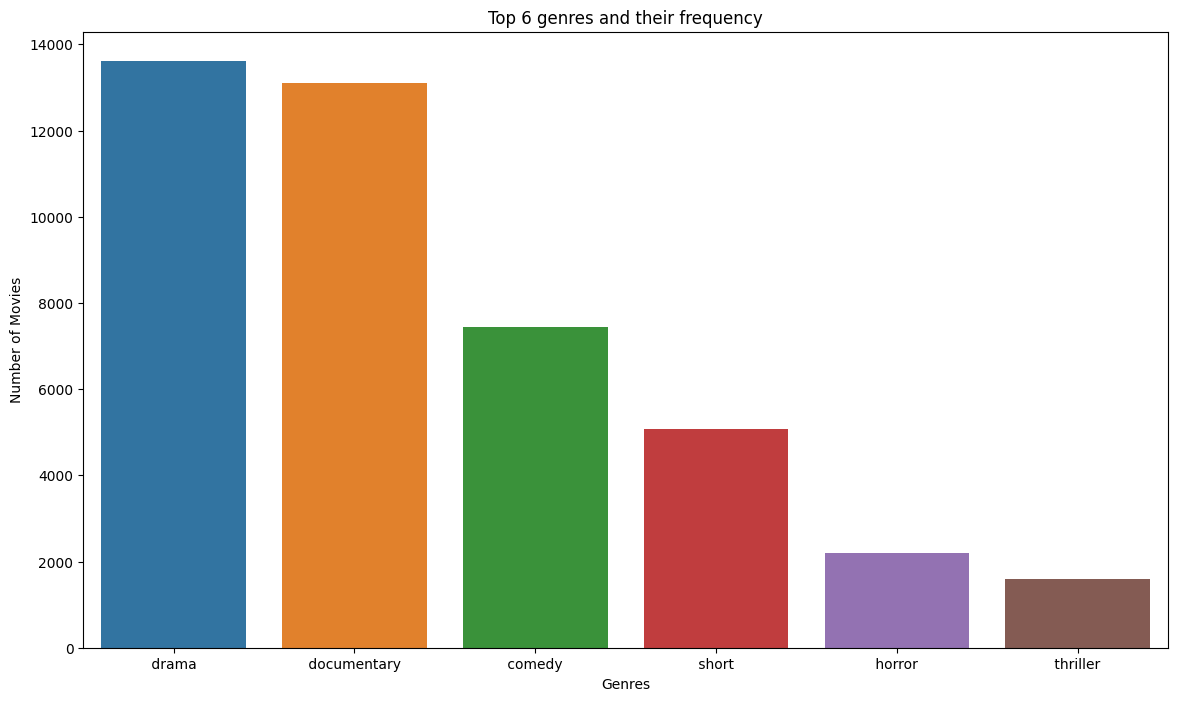

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(x=top_genres['genres'], y=top_genres['number_of_movies'])
plt.title('Top 6 genres and their frequency')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')

fig.savefig('./freqoftopgenres.png')

In [18]:
train_data['length']=train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


In [19]:
# Initialize the stemmer and stop words

stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

In [20]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

In [21]:
# # Apply the clean_text function to the 'Description' column in the training and test data
# nltk.download('punkt')

train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [22]:
train_data['length_Text_cleaning']=train_data['Text_cleaning'].apply(len)
train_data.head()

,Title,Genre,Description,length,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parents year old...,383
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,119
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empties students field trip museum natural...,402
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make ends meet edith tw...,745
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films title refers recovered bodies ground zer...,402


In [23]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['Text_cleaning'].values)

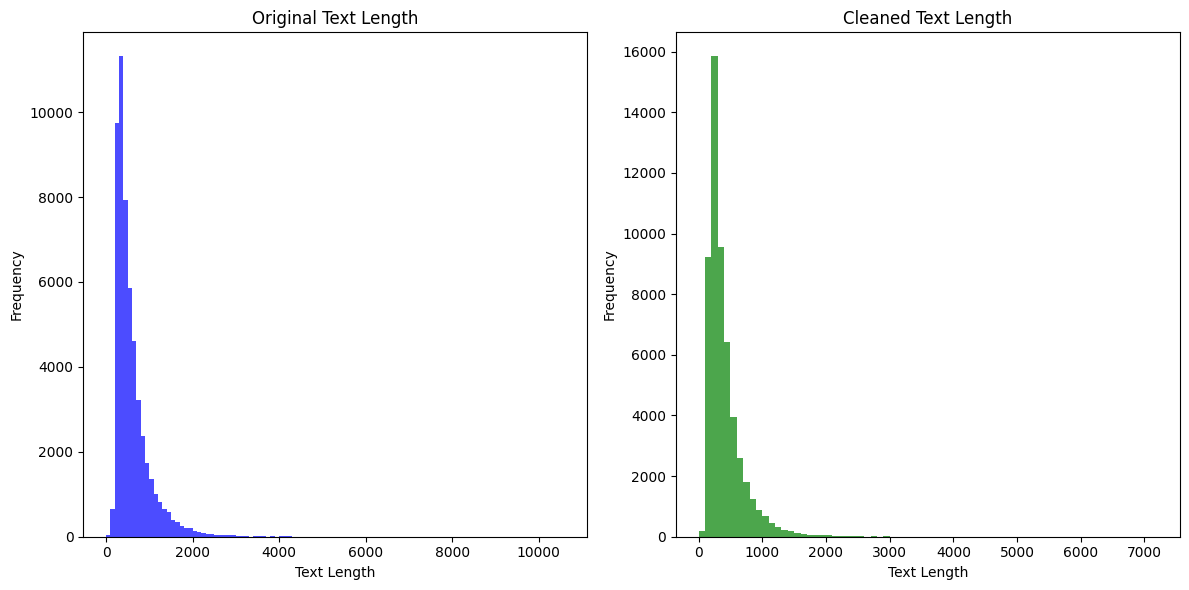

In [24]:
# Create histograms for text length before and after cleaning
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
(train_data['length_Text_cleaning']>2000).value_counts()

False    54014
True       200
Name: length_Text_cleaning, dtype: int64

In [26]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['length_Text_cleaning']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54014
Removed rows: 200


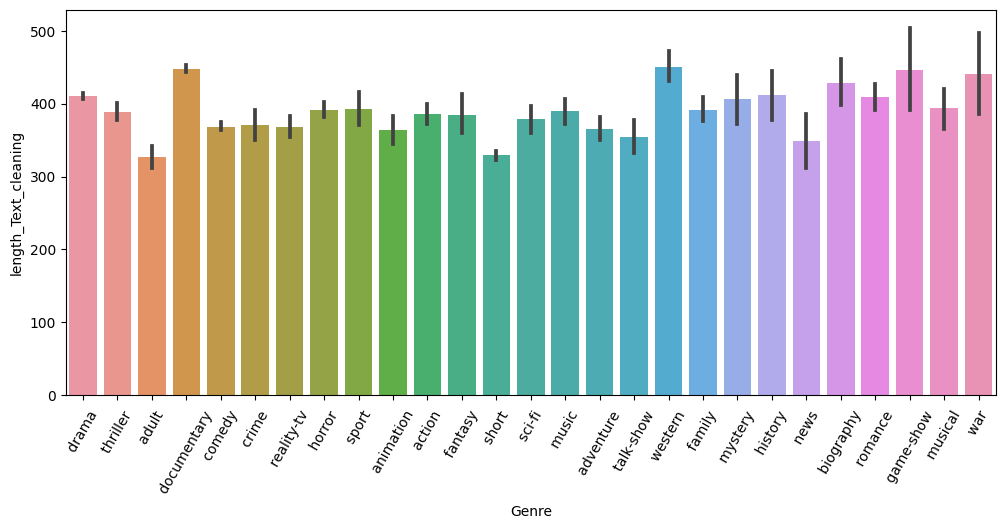

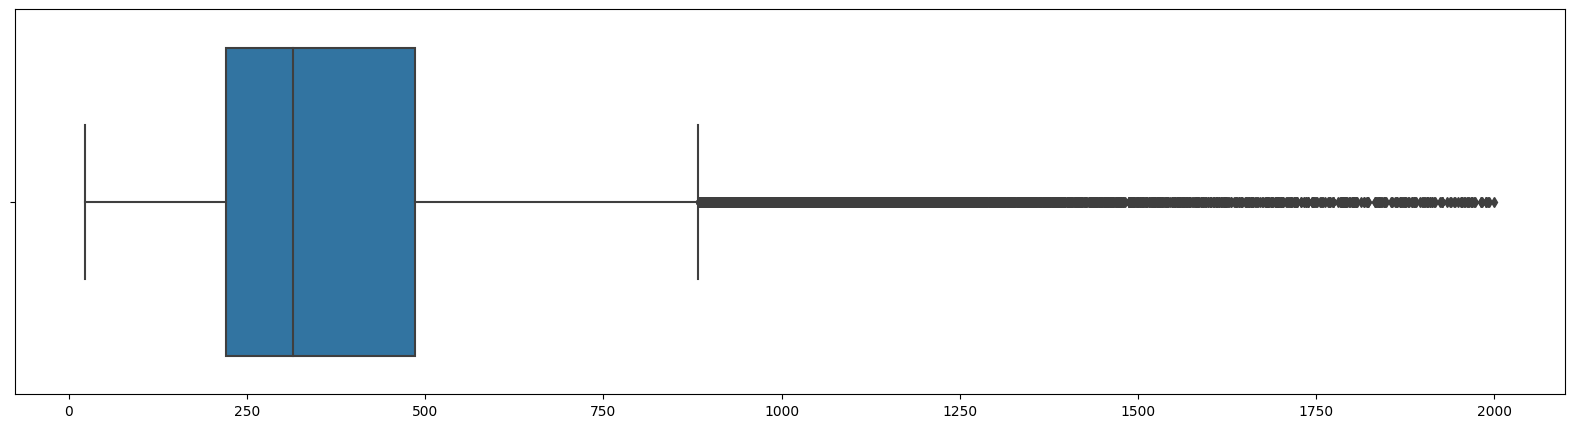

In [27]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre',y='length_Text_cleaning',data=train_data)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data['length_Text_cleaning'].values,hue='Genre',data=train_data)
plt.show()

In [28]:
test_data

,Id,Title,Description,Text_cleaning
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",covering multiple genres tales light dark anth...
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movie years making oliver twist artful dodger ...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock mike mallard askew bro...


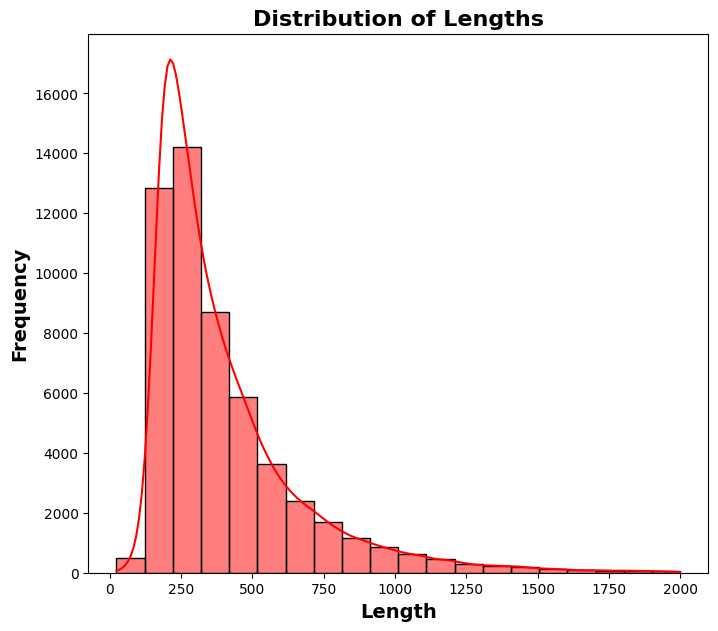

In [29]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='red')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

# **EDA & Data Visualization**

Text(0, 0.5, 'Genre')

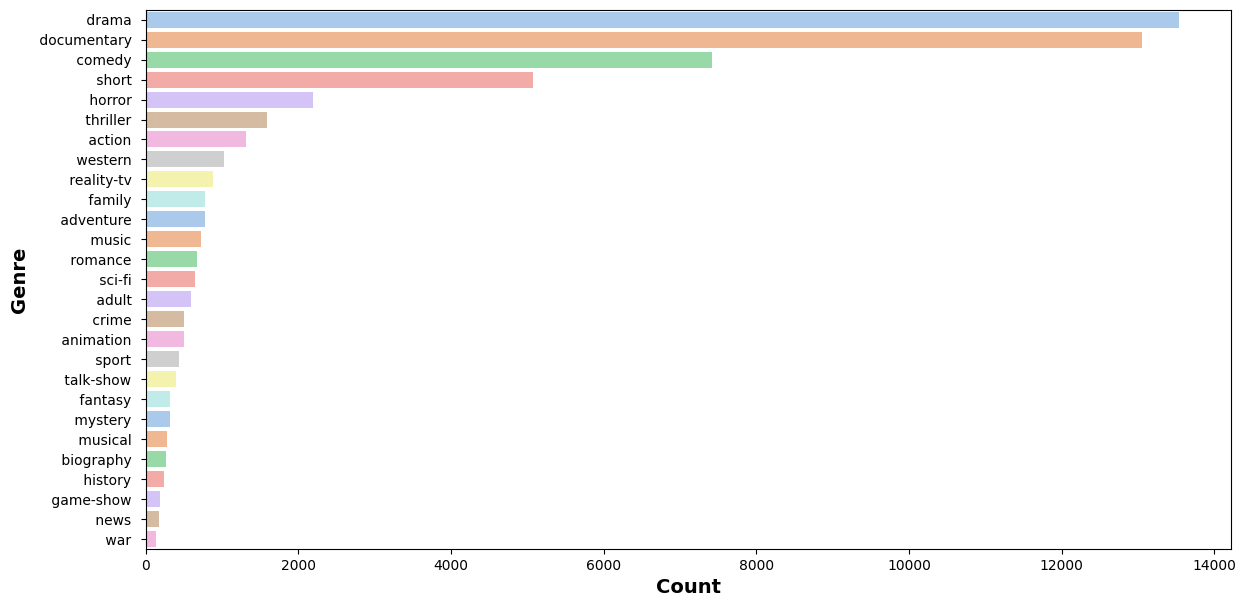

In [30]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='pastel')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

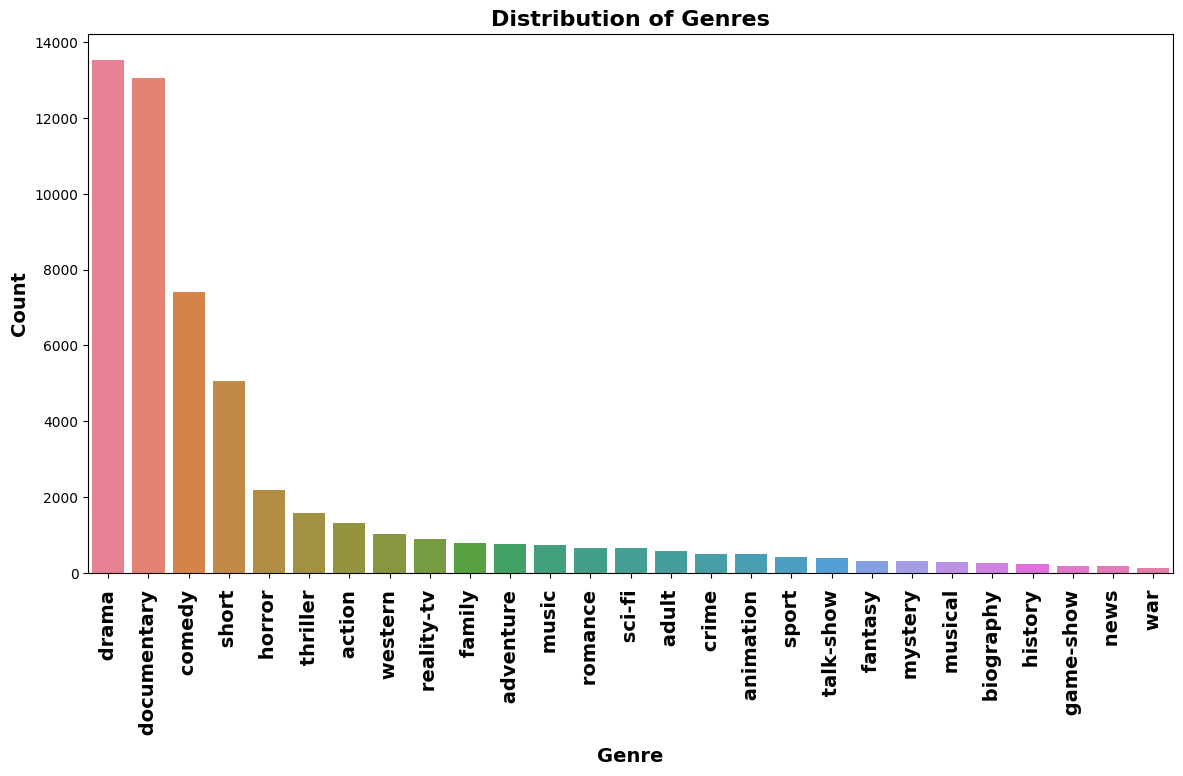

In [31]:
# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='husl')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

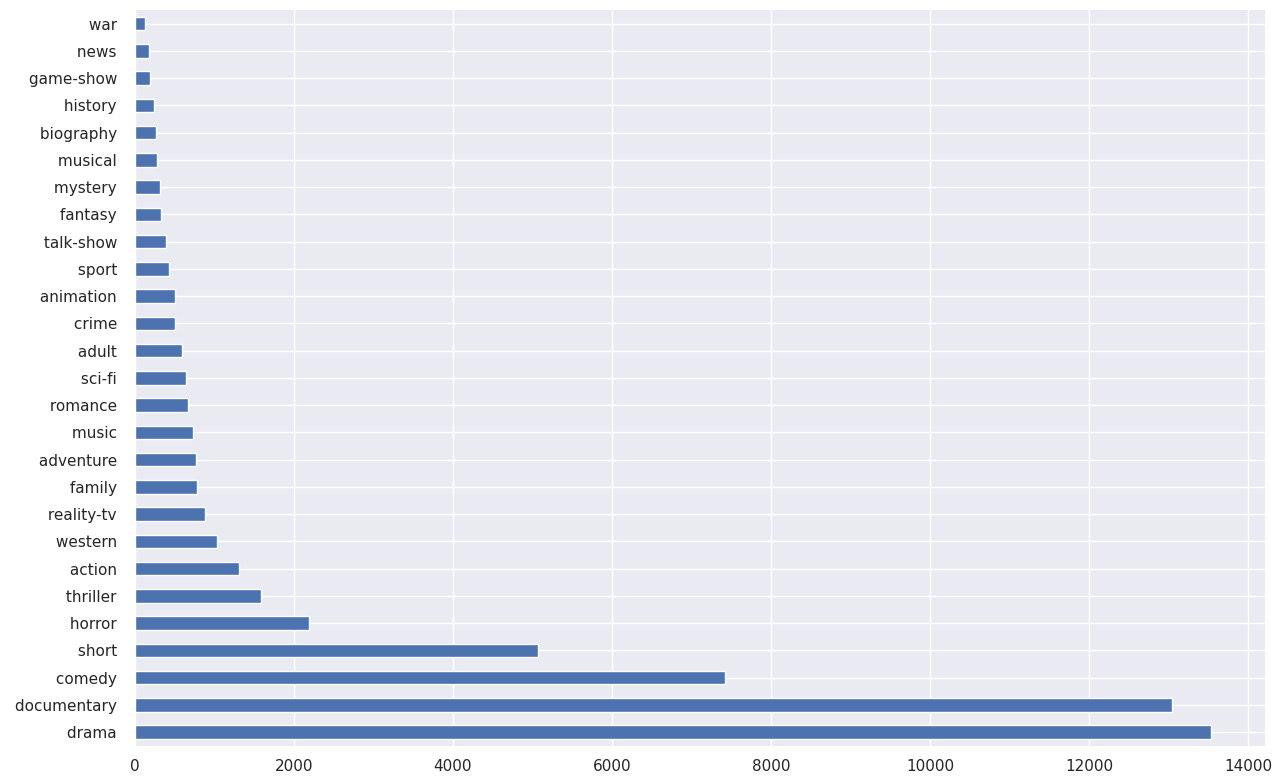

In [32]:
plt.figure(figsize=(13,8))

sns.set(style="darkgrid")
sns.set_color_codes("pastel")
train_data.Genre.value_counts().plot.barh()
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='Genre'>

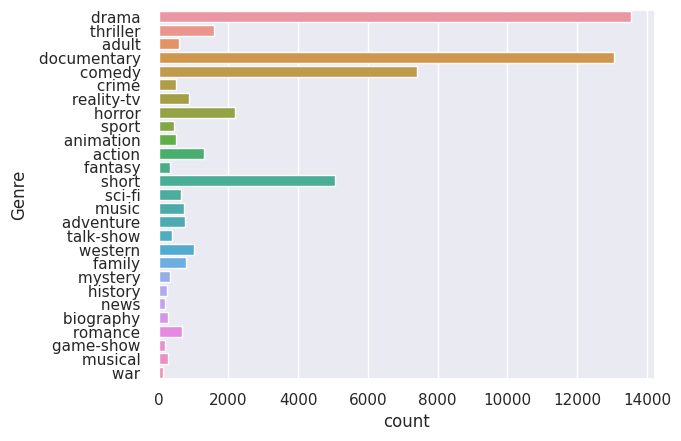

In [33]:
sns.countplot(y='Genre',data=train_data)

<Axes: ylabel='Frequency'>

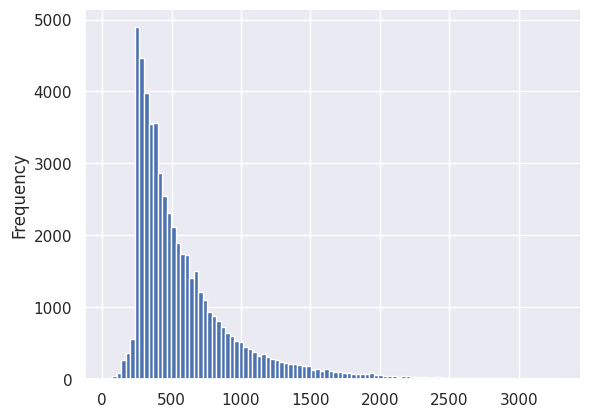

In [34]:
train_data['length'].plot(bins=100, kind='hist')

# **Text Vectorization Using TF-IDF**

In [35]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf.transform(test_data['Text_cleaning'])

# **Split Data and Train a Model (Naive Bayes)**

In [36]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44209123222748814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.00      0.00      0.00       331
       adult        0.00      0.00      0.00       148
   adventure        0.00      0.00      0.00       190
   animation        0.00      0.00      0.00       123
   biography        0.00      0.00      0.00        56
      comedy        0.58      0.03      0.05      1826
       crime        0.00      0.00      0.00       120
 documentary        0.53      0.89      0.67      3289
       drama        0.38      0.88      0.53      3391
      family        0.00      0.00      0.00       197
     fantasy        0.00      0.00      0.00        77
   game-show        0.00      0.00      0.00        51
     history        0.00      0.00      0.00        74
      horror        0.00      0.00      0.00       507
       music        0.00      0.00      0.00       180
     musical        0.00      0.00      0.00        66
     mystery        0.00      0.00      0.00        79
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dummy Classifier just predicting the most frequent class in the dataset gives us a 25% accuracy and we are going to be using that as our baseline accuracy moving forward

In [37]:
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
dummy_gs = GridSearchCV(dummy, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.25043199210071587


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/dummy.py", line 205, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant st

Grid Search with Multinomial Naive Bayes gave accuracy of ~50%

In [38]:
# Define the parameter grid
mnb_grid = {
    'alpha': [0.2, 0.5, 0.8, 1.0],  # Adjusted alpha values
    'fit_prior': [True, False],
    'class_prior': [None, [0.4, 0.3, 0.08, 0.07, 0.06, 0.06]]  # Adjusted class_prior values
}

# Create the MultinomialNB classifier
mnb = MultinomialNB()

# Create the GridSearchCV instance
mnb_tfidf_gs = GridSearchCV(mnb, param_grid=mnb_grid, cv=5, scoring='accuracy')

# Fit the model and perform hyperparameter tuning
mnb_tfidf_gs.fit(X_train, y_train)

# Print the best cross-validated score
print("Best Cross-Validated Score:", mnb_tfidf_gs.best_score_)

# Print the best parameters
print("Best Parameters:", mnb_tfidf_gs.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 775, in fit
    self._update_class_log_prior(class_prior=class_prior)
  File "/usr/local/lib/python3

Best Cross-Validated Score: 0.5038015304862997
Best Parameters: {'alpha': 0.2, 'class_prior': None, 'fit_prior': False}


# **Make Predictions on the Test Data**

In [42]:
#Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [43]:
#Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    